In [13]:
import numpy as np
import networkx as nx
from node2vec import Node2Vec
import random

from pyclustering.cluster import kmeans , clique

import os

from itertools import combinations 


import warnings
warnings.filterwarnings("ignore")

import sklearn
sklearn.__version__

'0.22.1'

In [14]:
def reading_graph(edgefile):
    #Reads the input network in networkx.
    G = nx.read_edgelist(edgefile, nodetype=int, create_using=nx.Graph())
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1
        
    return G

In [15]:
########## read the graph ##########

G22=reading_graph('edge_file.txt')

node_id1=list(G22.nodes())

test_list = list(map(int, node_id1)) 

test_list.sort()

#print(test_list)

node_id=test_list
print(node_id)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


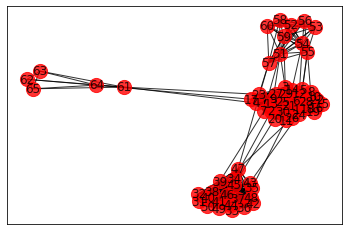

In [16]:
pos=nx.spring_layout(G22) # positions for all nodes
nx.draw_networkx(G22,pos,nodelist=node_id1, node_color='r', node_size=200, alpha=0.8)

In [17]:
def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
	for details
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

In [18]:
def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [19]:
    
import random

def uniform_draw(pr, Id):
    
### Draw uniform sampling based on probality distribution 

    pr_array=pr
    id_array=Id
        
    cum_pr_array=[]
    
    cumsum = 0
    for element in pr_array:
        cumsum += element
        cum_pr_array.append(cumsum)
 
    #print(cum_pr_array)
    #seed(1)
    x = random.random()
    length=len(cum_pr_array)
    
    for i in range(length):
        if x <  cum_pr_array[i]:
            return_node=id_array[i]
            break
            
    return return_node
        

In [20]:

class Graph():
	def __init__(self, nx_G, p, q, k):
		self.G = nx_G
		self.p = p
		self.q = q
		self.k = k
        
	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q
		k = self.k 

		unnormalized_probs = []
		sorted_node_id = []
        
		for dst_nbr in sorted(G.neighbors(dst)):
			if G.degree(dst_nbr) > k:
				if G.has_edge(dst_nbr, src):
					unnormalized_probs.append(G[dst][dst_nbr]['weight']*p)
					sorted_node_id.append(dst_nbr)
				else:
					unnormalized_probs.append(G[dst][dst_nbr]['weight']*q)
					sorted_node_id.append(dst_nbr)
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']*(1-p-q))
				sorted_node_id.append(dst_nbr)


                
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return normalized_probs, sorted_node_id


	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			sorted_node_id1=[nbr for nbr in sorted(G.neighbors(node))]            
			alias_nodes[node] = normalized_probs, sorted_node_id1



		alias_edges = {}
		triads = {}

		for edge in G.edges():
			alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
			alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
            
		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return
    
  
	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(uniform_draw(alias_nodes[cur][0], alias_nodes[cur][1]))
				else:
					prev = walk[-2]
					next = uniform_draw(alias_edges[(prev, cur)][0], alias_edges[(prev, cur)][1])
					walk.append(next)
			else:
				break

		return walk
    
	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print ('Walk iteration:')
		for walk_iter in range(num_walks):
			print (str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks



In [21]:
#######  initialize the grapg G22 with input parameters p (0.85), q (0.15), k(degree threshold: 10) : (p+q=1)

g22=Graph(G22, 0.85, 0.15, 10)

In [22]:
g22.preprocess_transition_probs()

In [26]:
###########  input parameters : number of walk _per source (here 10) and walk length (here 30)

import random
random_walk=g22.simulate_walks(10,30)
print(len(random_walk))

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
650


In [27]:
### save random walk file ###########

#os.remove('random_walk_file')

with open("random_walk_file", "w") as rwkfileid:

    #print(len(random_walk))
    
    for i3 in range(len(random_walk)):
        
        random_walk_set=random_walk[i3]
        
        #print(len(random_walk_set))
        
        for i4 in range(len(random_walk_set)):
            
            rwkfileid.write("%s " % int(random_walk_set[i4]))
            
        rwkfileid.write("\n")    
        

In [25]:
#####################################################################################################